In [1]:
pip install pennylane --upgrade

Requirement already up-to-date: pennylane in /opt/conda/lib/python3.8/site-packages (0.11.0)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install Pennylane-Cirq

Note: you may need to restart the kernel to use updated packages.


In [93]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [94]:
import pennylane as qml
from pennylane import numpy as np
from pennylane_cirq import ops as cirq_ops
import autograd.numpy as np   # Thinly-wrapped version of Numpy
from autograd import grad

In [95]:
#Noise model
import qiskit
from qiskit.providers.aer.noise.device import basic_device_noise_model

qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(group='open')
ibmq_16_melbourne = provider.get_backend('ibmq_16_melbourne')
device_properties = ibmq_16_melbourne.properties()

noise_model = basic_device_noise_model(device_properties)

ibmqfactory.load_account:WARNING:2020-09-21 16:47:33,156: Credentials are already in use. The existing account in the session will be replaced.
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:111: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  warnings.warn(


First let's try to optimize the angle of the first gate RY applied on qubit 0. The purpose of this gate is to produce a superposition of states |0> and |1> with probability 1/2 each. The angle will be optimized by looking at the cost function. The cost function depends on the expectation value of the superposition of two states. The state |0> is an eigenvector of the Pauli Z-matrix with eigenvalue 1 whereas the state |1> has eigenvalue -1, producing a total expectation value of 0. Thus, in order to find the optimized angle for the rotation RY gate we have to consider for which angle the cost function is equal to 0.

In [96]:
dev1 = qml.device("cirq.mixedsimulator", wires=2, shots=100)

In [97]:
def circuit_ry(params, noise_param=0.0):
    qml.RY(params[0], wires=0)
    cirq_ops.Depolarize(noise_param, wires=1)
    return qml.expval(qml.PauliZ(0))

gate_pars = [0.54, 0.12, 0.4]
print("Expectation value:", circuit_ry(gate_pars))

Expectation value: PauliZ: 0 params, wires [0]


In [98]:
@qml.qnode(dev1)
def circuit_ry(params, noise_param=0.0):
    qml.RY(params[0], wires=0)
    cirq_ops.Depolarize(noise_param, wires=1)
    return qml.expval(qml.PauliZ(0))

In [99]:
print(circuit_ry([0.06, 0.12, 0.06]))

0.9982005378114991


In [100]:
@qml.qnode(dev1)
def circuit2_ry(phi1, noise_param=0.0):
    qml.RY(phi1, wires=0)
    cirq_ops.Depolarize(noise_param, wires=1)
    return qml.expval(qml.PauliZ(0))

In [101]:
dcircuit = qml.grad(circuit2_ry, argnum=[0])
print(dcircuit(0.54))

(array(-0.51413603),)


In [102]:
def cost(x):
    return circuit_ry(x)

In [103]:
def noisy_cost(x):
    return circuit_ry(x, noise_param=0.001)

In [104]:
init_params = np.array([0.05])
print(cost(init_params))

0.9987502350704744


In [105]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.025)

# set the number of steps
steps = 1000
# set the initial parameter values
params = init_params
noisy_circuit_params = init_params

for i in range(steps):
    # update the circuit parameters
    # we can optimize both in the same training loop
    params = opt.step(cost, params)
    noisy_circuit_params = opt.step(noisy_cost, noisy_circuit_params)

    if (i + 1) % 2 == 0:
        
        print("Step {:5d}. Cost: {: .7f}; Noisy Cost: {: .7f}"
              .format(i + 1,
                      cost(params),
                      noisy_cost(noisy_circuit_params)))
        print("\nOptimized rotation angle Ry (noise-free case):")
        print("{: .7f}".format(*params))
        print("Optimized rotation angle Ry (noisy case):")
        print("{: .7f}".format(*noisy_circuit_params))

Step     2. Cost:  0.9986206; Noisy Cost:  0.9986206

Optimized rotation angle Ry (noise-free case):
 0.0525302
Optimized rotation angle Ry (noisy case):
 0.0525302
Step     4. Cost:  0.9984775; Noisy Cost:  0.9984774

Optimized rotation angle Ry (noise-free case):
 0.0551882
Optimized rotation angle Ry (noisy case):
 0.0551882
Step     6. Cost:  0.9983195; Noisy Cost:  0.9983195

Optimized rotation angle Ry (noise-free case):
 0.0579807
Optimized rotation angle Ry (noisy case):
 0.0579807
Step     8. Cost:  0.9981453; Noisy Cost:  0.9981453

Optimized rotation angle Ry (noise-free case):
 0.0609142
Optimized rotation angle Ry (noisy case):
 0.0609142
Step    10. Cost:  0.9979529; Noisy Cost:  0.9979529

Optimized rotation angle Ry (noise-free case):
 0.0639960
Optimized rotation angle Ry (noisy case):
 0.0639960
Step    12. Cost:  0.9977407; Noisy Cost:  0.9977406

Optimized rotation angle Ry (noise-free case):
 0.0672335
Optimized rotation angle Ry (noisy case):
 0.0672335
Step    14

Here we optimize the RX_1 gate which acts on qubit 1 (the second qubit).  The purpose of this gate is to change state |0> to state |1>. The optimized angle for this gate corresponds to a cost function equal to -1 because the state |1> is an eigenvector of the Pauli Z-matrix with eigenvalue of -1, which means that we measure this state with an expectation of -1 and as the cost function directly depends on the expectation this means that the cost function should also be -1.


This gate will add some phase in our circuit, which is undesirable. In order to eliminate this phase, we can add another RX gate on qubit 0, immediately after gate RY. The angle of this gate, RX_0, should be equal to RX_1 in absolute value but opposite in sign. First we find the optimized angle of RX_1 and from that the angle of RX_0 can be found in a straightforward way simply by changing the sign of RX_1.

In [106]:
def circuit_rx1(params, noise_param=0.0):
    qml.RX(params[0], wires=0)
    cirq_ops.Depolarize(noise_param, wires=1)
    return qml.expval(qml.PauliZ(0))

gate_pars = [0.54, 0.12, 0.4]
print("Expectation value:", circuit_rx1(gate_pars))

Expectation value: PauliZ: 0 params, wires [0]


In [107]:
@qml.qnode(dev1)
def circuit_rx1(params, noise_param=0.0):
    qml.RX(params[0], wires=0)
    cirq_ops.Depolarize(noise_param, wires=1)
    return qml.expval(qml.PauliZ(0))

In [108]:
@qml.qnode(dev1)
def circuit2_rx1(phi2,noise_param=0.0):
    qml.RX(phi2, wires=0)
    cirq_ops.Depolarize(noise_param, wires=1)

    return qml.expval(qml.PauliZ(0))

In [109]:
dcircuit = qml.grad(circuit2_rx1, argnum=[0])
print(dcircuit(0.54))

(array(-0.51413603),)


In [110]:
def cost(x):
    return circuit_rx1(x)

In [111]:
def noisy_cost(x):
    return circuit_rx1(x, noise_param=0.001)

In [112]:
init_params = np.array([0.05])
print(cost(init_params))

0.9987502350704744


In [113]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.025)

# set the number of steps
steps = 1000
# set the initial parameter values
params = init_params
noisy_circuit_params = init_params


for i in range(steps):
    # update the circuit parameters
    # we can optimize both in the same training loop
    params = opt.step(cost, params)
    noisy_circuit_params = opt.step(noisy_cost, noisy_circuit_params)

    if (i + 1) % 2 == 0:
        
        print("Step {:5d}. Cost: {: .7f}; Noisy Cost: {: .7f}"
              .format(i + 1,
                      cost(params),
                      noisy_cost(noisy_circuit_params)))
        print("\nOptimized rotation angle Rx_1 (noise-free case):")
        print("{: .7f}".format(*params))
        print("Optimized rotation angle Rx_1 (noisy case):")
        print("{: .7f}".format(*noisy_circuit_params))

Step     2. Cost:  0.9986206; Noisy Cost:  0.9986206

Optimized rotation angle Rx_1 (noise-free case):
 0.0525302
Optimized rotation angle Rx_1 (noisy case):
 0.0525302
Step     4. Cost:  0.9984775; Noisy Cost:  0.9984774

Optimized rotation angle Rx_1 (noise-free case):
 0.0551882
Optimized rotation angle Rx_1 (noisy case):
 0.0551882
Step     6. Cost:  0.9983195; Noisy Cost:  0.9983195

Optimized rotation angle Rx_1 (noise-free case):
 0.0579807
Optimized rotation angle Rx_1 (noisy case):
 0.0579807
Step     8. Cost:  0.9981453; Noisy Cost:  0.9981453

Optimized rotation angle Rx_1 (noise-free case):
 0.0609142
Optimized rotation angle Rx_1 (noisy case):
 0.0609142
Step    10. Cost:  0.9979529; Noisy Cost:  0.9979529

Optimized rotation angle Rx_1 (noise-free case):
 0.0639960
Optimized rotation angle Rx_1 (noisy case):
 0.0639960
Step    12. Cost:  0.9977407; Noisy Cost:  0.9977406

Optimized rotation angle Rx_1 (noise-free case):
 0.0672335
Optimized rotation angle Rx_1 (noisy case

Conclusions:

The GradientDescentOptimizer generates an angle of pi/2 for gate RY (Cost=0).

For the gate RX_1 generates an angle of pi (3.141....) where the cost is -1.

Consequently we can deduce the angle of RX_0 as -pi, following our previous logic.

Increasing the number of steps from 1, 10, 100, 1000, increases the accuracy of the results.

We can use the Circuit Composer on IBM Quantum Experience (or any other platform) to simulate the circuit for the given gates and angles and see the results. After the rotation gates, a CNOT gate is required between wire 0 and wire 1 to produce the superposition: (|01> + |10>) / (sqrt2).

The Measurement Probabilities graph and Q-sphere show that we measure the states |01> and |10> with probability 50% each and with a phase of 2*pi.

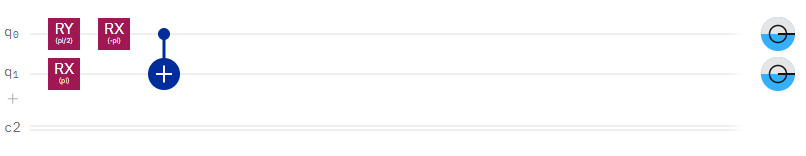


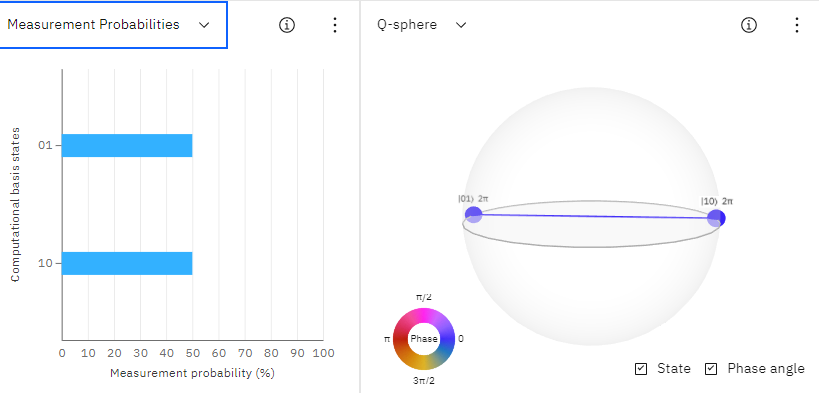

In order to observe the changes that occur when we use different number of shots, I did not use Pennylane or IBMQ, but I simulated the circuit in the Quantum-Inspire platform using a depolarizing channel error model of probability 0.001. I  chose this platform for this purpose because it was easier to observe any changes in the measurement results occuring as a consequence of changing the number of shots.

I tried different number of shots, 1, 10, 100, 1000. For larger number of shots it can be seen that errors appear in the superposition probabilities. For N=100 and N=1000 we don't receive the desired states with probability 50% and in addition to that new states appear, with small probability. These results would be even worse if the probability error was higher.

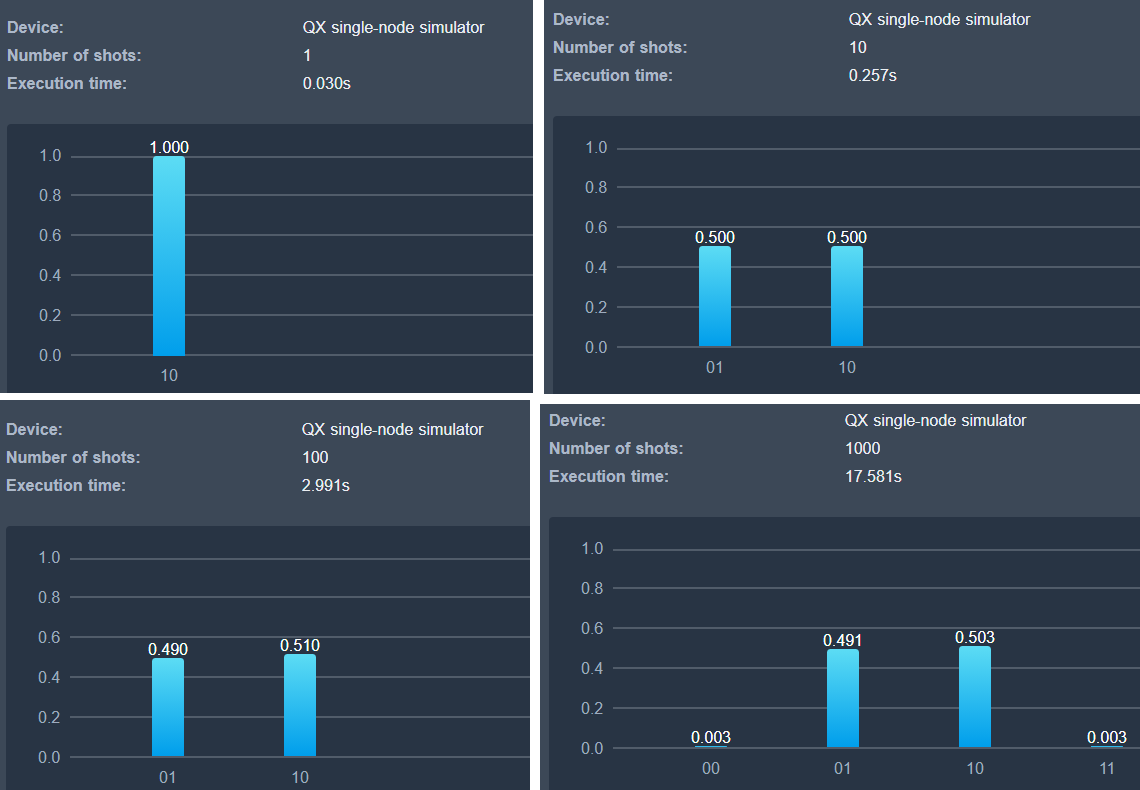